# AI in Medicine I - Practical 2: Brain Tissue Segmentation

Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the coursework is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

Before you start to solve the exercise, please write your TUM-IDs alongside the names of all group members. This will enable us to assign grades accurately. Thank you.

Member 1: Pham, Doan Xuan Viet; 03698056

Member 2: Schulz, Julien; 03723706

Member 3: Jehkul, Janik; 03781262

## Downloading the Data

In [1]:
! wget -q --show-progress https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip -qq -o brainage-data.zip
! wget -q --show-progress https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip -qq -o brainage-testdata.zip
! pip install monai

brainage-data.zip.2 100%[===================>] 446.94M  64.8MB/s    in 7.4s    
brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      


## Imports

In [2]:
import os
import glob
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def load_nii(path: str, dtype: str = 'float32') -> np.ndarray:
    """Load an MRI scan from disk and convert it to a given datatype

    :param path: Path to file
    :param dtype: Target dtype
    :return img: Loaded image. Shape (H, W, D)
    """
    return nib.load(path).get_fdata().astype(np.dtype(dtype))


def load_segmentations(paths: str):
    """Load all segmentations and associated subject_ids"""
    filenames, segmentations = [], []
    for im in tqdm(paths):
        id = im.split('_brain_')[0].split('/')[-1].split('-')[1].split('_')[0]
        segmentations.append(load_nii(im))
        filenames.append(id)
    return filenames, np.array(segmentations)


def plot_segmentations(im: np.ndarray, seg: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    col = 2
    ax[0, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].set_title('Axial')

    k = 1
    col = 0
    ax[0, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[i, ...], k=k),
                 alpha=0.5 * (np.rot90(seg[i, ...] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].set_title('Sagittal')

    col = 1
    ax[0, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[:, i, :], k=k),
                 alpha=0.5 * (np.rot90(seg[:, i, :] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].set_title('Coronal')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()



%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

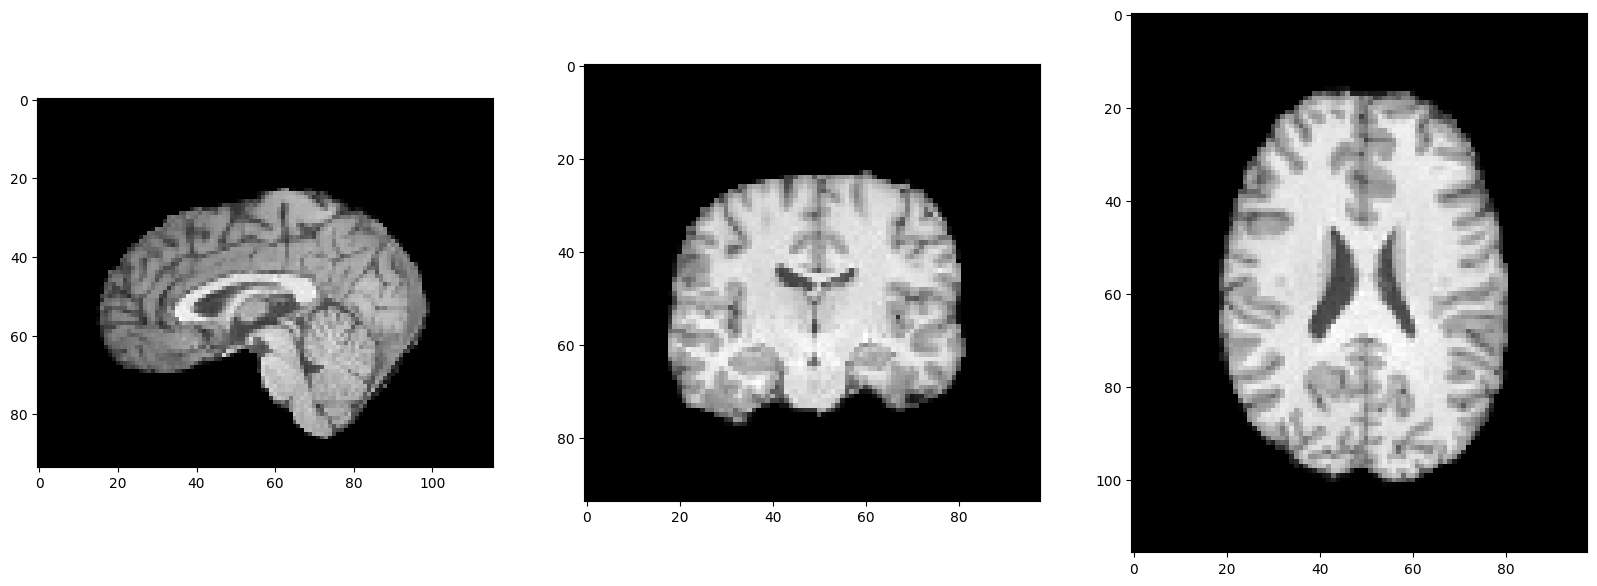

In [3]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [4]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:08<00:00, 74.63it/s]


In [5]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], []
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|██████████| 652/652 [00:00<00:00, 69076.92it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample

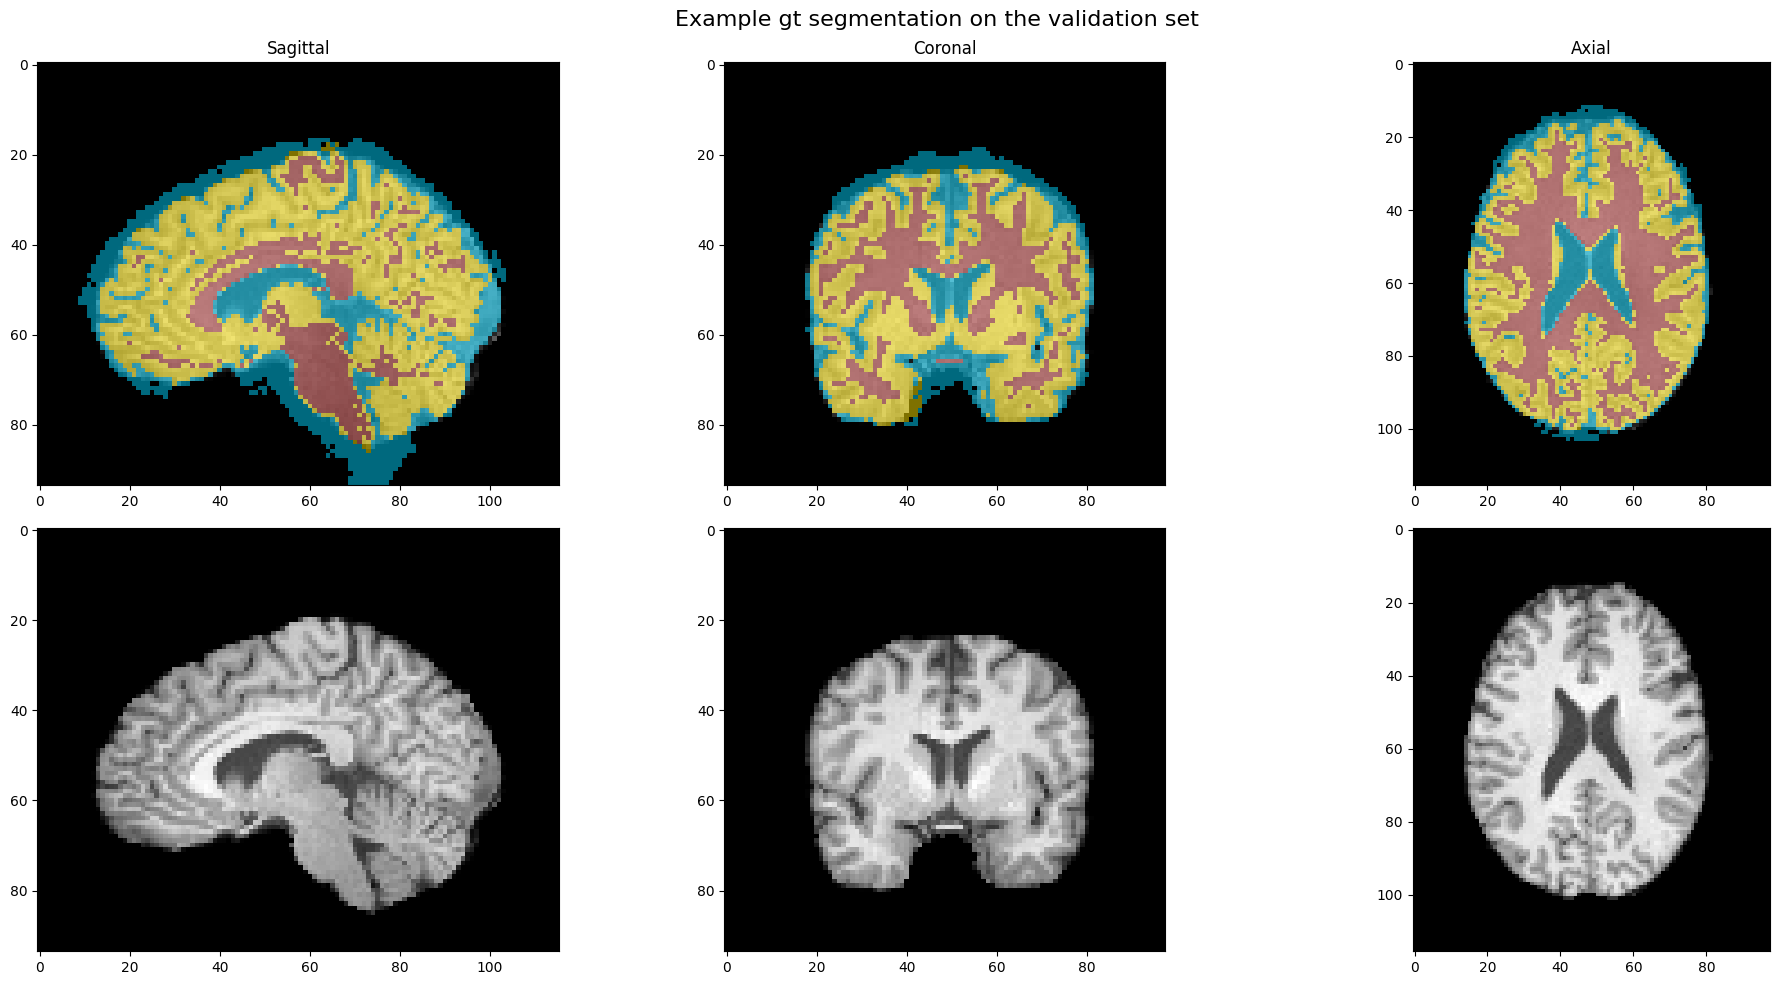

In [6]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47, title='Example gt segmentation on the validation set')

# Task 1: Evaluation and Visualization

**Q1a**. We first have to define how good our predicted segmentations are. Implement the evaluation functions below.

In [7]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms.
# Implement a method that computes the patient-wise Dice score, precision, and recall (mean and std) for the test dataset.
# Hint: Don't forget that there are multiple classes.
# --------------------------- ADD YOUR CODE HERE ------------------------------
# (#0 = bg, 1 = CSF, 2 = WM, 3 = GM) => range(4)
def Dice(predictions, gt, index=None):
  mean, std = None, None
  dice_scores = []
  if index == None:
    for i in range(4):
          intersection = np.sum(predictions[gt==i]==i)
          dice_score = (2. * intersection) / (np.sum(predictions[gt==i]==i) + np.sum(gt[gt==i]==i))
          dice_scores.append(dice_score)
  else:
      intersection = np.sum(predictions[gt==index]==index)
      dice_score = (2. * intersection) / (np.sum(predictions[gt==index]==index) + np.sum(gt[gt==index]==index))
      dice_scores.append(dice_score)

  mean = np.mean(dice_scores)
  std = np.std(dice_scores)
  return mean, std

def precision(predictions, gt, index=None):
    mean, std = None, None
    precision_scores = []
    if index is None:
        for i in range(4):
            tp = np.sum((predictions[gt == i] == i))
            fp = np.sum((predictions[gt != i] == i))
            precision_score = (tp) / (tp + fp)
            precision_scores.append(precision_score)
    else:
            tp = np.sum((predictions[gt == index] == index))
            fp = np.sum((predictions[gt != index] == index))
            precision_score = (tp) / (tp + fp)
            precision_scores.append(precision_score)

    mean = np.mean(precision_scores)
    std = np.std(precision_scores)
    return mean, std

def recall(predictions, gt, index=None):
    mean, std = None, None
    recall_scores = []
    if index is None:
        for i in range(4):
            tp = np.sum((predictions[gt == i] == i))
            fn = np.sum((predictions[gt == i] != i))
            recall_score = (tp) / (tp + fn)
            recall_scores.append(recall_score)
    else:
            tp = np.sum((predictions[gt == index] == index))
            fn = np.sum((predictions[gt == index] != index))
            recall_score = (tp) / (tp + fn)
            recall_scores.append(recall_score)

    mean = np.mean(recall_scores)
    std = np.std(recall_scores)
    return mean, std
# ----------------------------------- END -------------------------------------
#print("Identity 0 : Dice: " + str(Dice(segmentations_test[0], segmentations_test[0])) + " Precision: " + str(precision(segmentations_test[0], segmentations_test[0])) + " Recall: " + str(recall(segmentations_test[0], segmentations_test[0])))
#print("Pred 0 : Dice: " + str(Dice(pred_seg_1[0], segmentations_test[0])) + " Precision: " + str(precision(pred_seg_1[0], segmentations_test[0])) + " Recall: " + str(recall(pred_seg_1[0], segmentations_test[0])))
#print("Identity 1 : Dice: " + str(Dice(segmentations_test[1], segmentations_test[1])) + " Precision: " + str(precision(segmentations_test[1], segmentations_test[1])) + " Recall: " + str(recall(segmentations_test[1], segmentations_test[1])))
#print("Pred 1 : Dice: " + str(Dice(pred_seg_1[1], segmentations_test[1])) + " Precision: " + str(precision(pred_seg_1[1], segmentations_test[1])) + " Recall: " + str(recall(pred_seg_1[1], segmentations_test[1])))

**Q1b**. Next, we want to visualize the best- and worst-performing samples in the test set. Implement a function that evaluates the entire test dataset and outputs the index of the best and worst performing samples according to the Dice coefficient.

In [8]:
# You may change the functions below as you see fit

# --------------------------- ADD YOUR CODE HERE ------------------------------
def get_best_and_worst_ids(predictions):
    best_ids, worst_ids = -1, -1
    best_performance, worst_performance = None, None

    # TODO: implement
    patient_mean_dice = []
    patient_std_dice = []

    for i in range(len(predictions)):
        mean_dice, std_dice = Dice(predictions[i], segmentations_test[i])
        patient_mean_dice.append(mean_dice)
        patient_std_dice.append(std_dice)

    best_ids = np.argmax(patient_mean_dice)
    worst_ids = np.argmin(patient_mean_dice)
    best_performance = patient_mean_dice[best_ids]
    worst_performance = patient_mean_dice[worst_ids]

    return {
        'best_id': best_ids,
        'best_performance': best_performance,
        'worst_id': worst_ids,
        'worst_performance': worst_performance
    }

def visualize_best_and_worst_samples(predictions, i_best=47, i_worst=47):
    return_dict = get_best_and_worst_ids(predictions)

    best_id = return_dict['best_id']
    plot_segmentations(load_nii(test_files[best_id]), predictions[best_id], i=i_best,
                       title=f'Best prediction on the test set (Dice: {return_dict["best_performance"]:.2f})')

    worst_id = return_dict['worst_id']
    plot_segmentations(load_nii(test_files[worst_id]), predictions[worst_id], i=i_worst,
                       title=f'Worst prediction on the test set (Dice: {return_dict["worst_performance"]:.2f})')

# ----------------------------------- END -------------------------------------


**Q1c**. Given a set of predictions for a number of models, create a summary figure of your choice (e.g. table, bar plot) which visualizes all of the metric values. Visualize multiple metrics (Dice coefficient, precision, and recall), each computed for every tissue type. A sample dictionary is provided below.

In [9]:
# --------------------------- ADD YOUR CODE HERE ------------------------------

def get_results_dictionary(predictions):
    results_dict =  {}
    # TODO: implement
    for i in range(len(predictions)):
      baseline = f'baseline{i+1}'
      results_dict[baseline] = {
      'CSF': {'dice': Dice(predictions[i], segmentations_test[i], 1)[0], 'precision':precision(predictions[i], segmentations_test[i], 1)[0], 'recall': recall(predictions[i], segmentations_test[i], 1)[0]},
      'WM': {'dice': Dice(predictions[i], segmentations_test[i], 3)[0], 'precision': precision(predictions[i], segmentations_test[i], 3)[0], 'recall': recall(predictions[i], segmentations_test[i], 3)[0]},
      'GM': {'dice': Dice(predictions[i], segmentations_test[i], 2)[0], 'precision': precision(predictions[i], segmentations_test[i], 2)[0], 'recall': recall(predictions[i], segmentations_test[i], 2)[0]},
    }
    return results_dict

def plot_results_summary(results_dict: Dict[str, Dict[str, Dict[str, str]]]) -> None:
    # TODO: implement
    mean_results = {}
    for method in results_dict:
        mean_results[method] = {}
        for metric in ['dice', 'precision', 'recall']:
            mean_results[method][metric] = {}
            for tissue in ['CSF', 'WM', 'GM']:
                mean_results[method][metric][tissue] = np.mean([float(results_dictionary[method][baseline][tissue][metric]) for baseline in results_dictionary[method]])

    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
    fig.suptitle('Mean of different metrics')

    colors = ['#308fac', '#37bd79', '#a7e237']

    for i, (method, metrics) in enumerate(mean_results.items()):
        for j, (metric, tissues) in enumerate(metrics.items()):
            axes[i].bar(np.arange(len(tissues)) + j*0.25, tissues.values(), width=0.25, label=metric, color=colors[j])
        axes[i].set_title(method)
        axes[i].set_xticks(np.arange(len(tissues)) + 0.25)
        axes[i].set_xticklabels(tissues.keys())
        axes[i].legend()

    plt.show()

# ----------------------------------- END -------------------------------------

sample_results = {
    'baseline1': {
        'CSF': {'dice': '0.7', 'precision': '0.82', 'recall': '0.6'},
        'WM': {'dice': '0.72', 'precision': '0.86', 'recall': '0.61'},
        'GM': {'dice': '0.74', 'precision': '0.88', 'recall': '0.59'},
    },
    'baseline2': {
        'CSF': {'dice': '0.6', 'precision': '0.5', 'recall': '0.7'},
        'WM': {'dice': '0.61', 'precision': '0.4', 'recall': '0.72'},
        'GM': {'dice': '0.9', 'precision': '0.88', 'recall': '0.92'},
    }}

results_dictionary = {
    'unsupervised1': sample_results,
    'unsupervised2': sample_results,
    'u-net': sample_results,
}
#plot_results_summary(results_dictionary)

# Task 2: Unsupervised segmentation

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored.

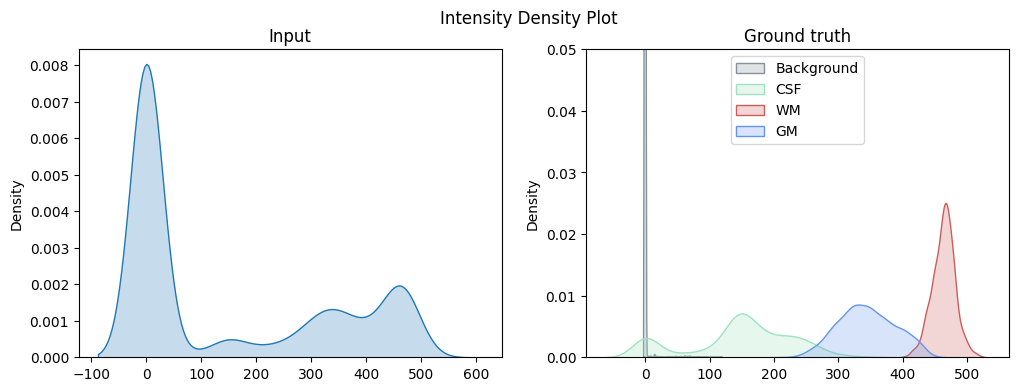

In [10]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

## Unsupervised Learning

Here, you should experiment with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc... (at least two different methods). Hint: sklearn has implementations of unsupervised methods

**HINT**: You can predict the different classes of intensities even without any training!

**HINT**: You can evaluate every volume slice-by-slice if the whole volume does not fit in the memory.

#### QUESTION Q2a.
Implement an unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 1.

In [11]:
# Unsupervised method 1
# --------------------------- ADD YOUR CODE HERE ------------------------------
from sklearn.cluster import MiniBatchKMeans

pred_seg_1 = []
cluster_assignments = []

mbkmeans = MiniBatchKMeans(n_clusters=4, random_state=1)

for train_file in train_files:
    train_image = nib.load(train_file).get_fdata()
    flat_train_image = train_image.flatten().reshape(-1, 1)
    mbkmeans.partial_fit(flat_train_image)

for test_file in test_files:
    test_image = nib.load(test_file).get_fdata()
    flat_test_image = test_image.flatten().reshape(-1, 1)
    cluster_assignment = mbkmeans.predict(flat_test_image)
    cluster_assignments.append(cluster_assignment)
    # TODO:
    # wird das pred_seg_1 hier nicht einfach gleich wieder überschrieben in der nächsten Zelle?
    pred_seg_1.append(cluster_assignment.reshape(test_image.shape))

# ----------------------------------- END -------------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
# Map (#0 = bg, 1 = GM, 2 = WM, 3 = CSF) => (#0 = bg, 1 = CSF, 2 = WM, 3 = GM))

label_mapping = {0: 10, 1: 20, 2: 30, 3: 40}
temp_labels = np.vectorize(label_mapping.get)(cluster_assignments)
label_mapping_2 = {10: 0, 40: 1, 30: 2, 20: 3}
corrected_labels = np.vectorize(label_mapping_2.get)(temp_labels)

test_images = [nib.load(test_file).get_fdata() for test_file in test_files]
pred_seg_1 = [clusters.reshape(img.shape) for img, clusters in zip(test_images, np.split(corrected_labels, len(test_images)))]

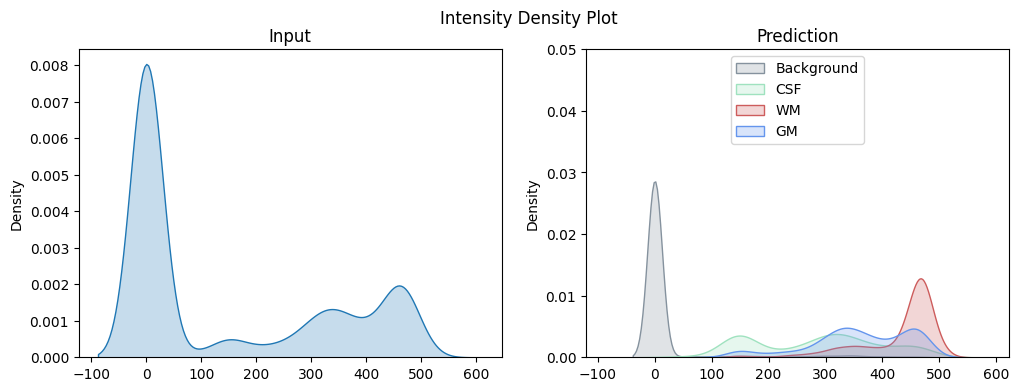

In [13]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_1 = None
pred_ = pred_seg_1[slice_id][:,:,47].flatten()
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(pred_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(pred_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(pred_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(pred_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Prediction')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])


# ----------------------------------- END -------------------------------------

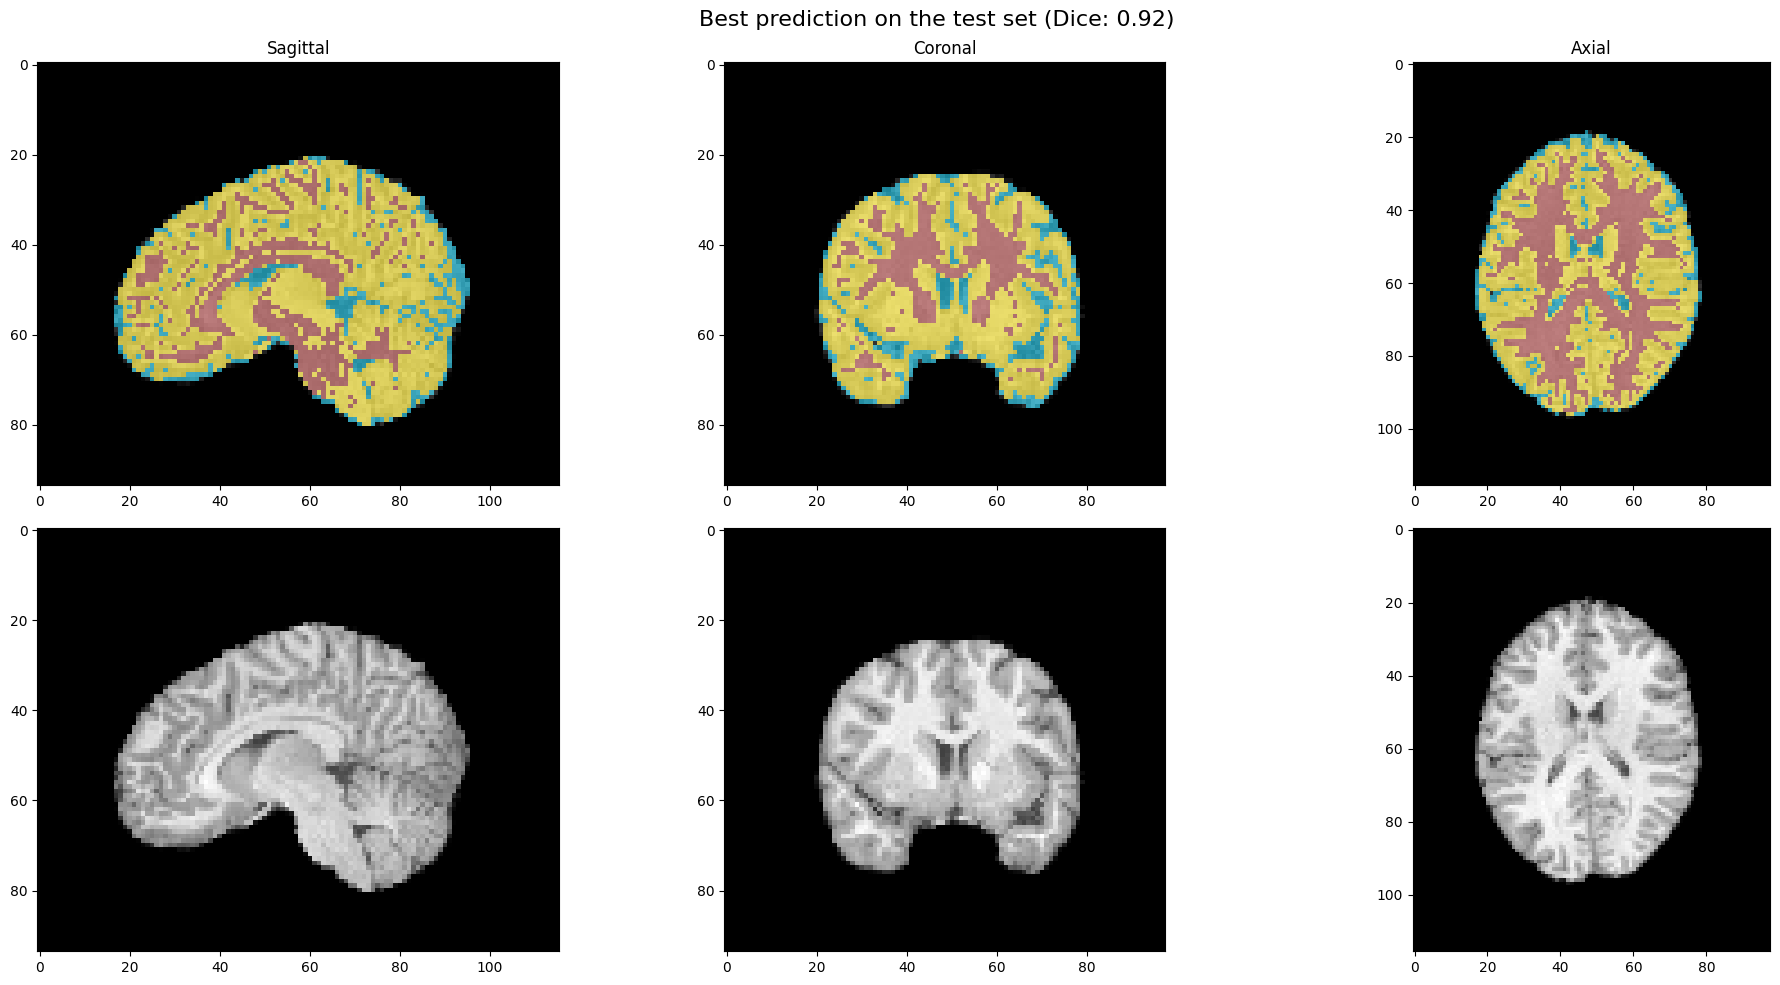

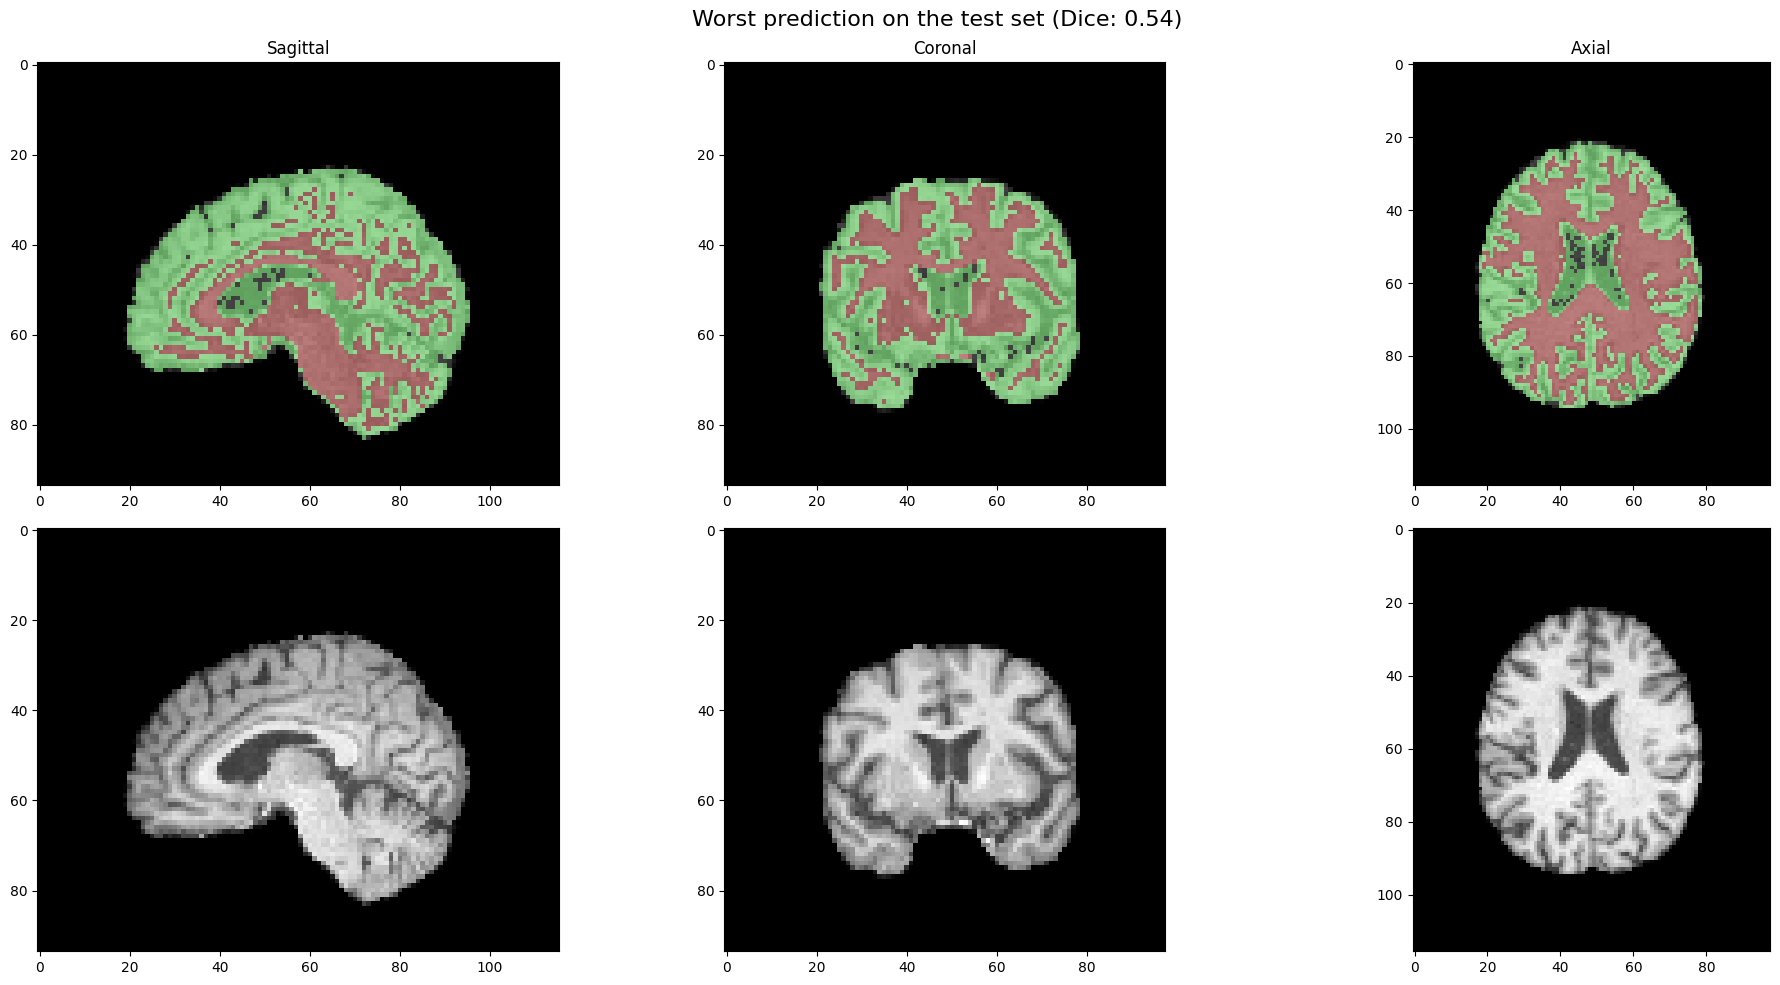

In [14]:
# Visualize the best and worst predictions on the test set for method 1
visualize_best_and_worst_samples(pred_seg_1)

#### QUESTION Q2b.
Implement a second unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2.

In [11]:
# Unsupervised method 2
# --------------------------- ADD YOUR CODE HERE ------------------------------
from sklearn.mixture import GaussianMixture

pred_seg_2 = []
cluster_assignments = []
batch_size = 32

#val_images = [nib.load(val_file).get_fdata() for val_file in val_files]
#flat_images = np.concatenate([img.flatten() for img in val_images]).reshape(-1, 1)


# initialize the GMM
gmm = GaussianMixture(n_components=4, covariance_type='diag', init_params='kmeans', warm_start=True)

print("fitting...")
# iterate over the self made minibatches and fit the GMM
#last_batch = len(train_files) % batch_size
#for i in range(0, len(train_files), batch_size):
#  raw_batch = train_files[i:min(i+batch_size, len(train_files))]
#  loaded_batch = np.concatenate([nib.load(train_file).get_fdata().flatten() for train_file in raw_batch]).reshape(-1, 1)
#  gmm.fit(loaded_batch)


# Calculate the number of batches
num_batches = len(train_files) // batch_size
if len(train_files) % batch_size != 0:
    num_batches += 1
# Iterate over each batch
for i in range(num_batches):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, len(train_files))
    batch_files = train_files[start_index:end_index]
    loaded_batch = np.concatenate([nib.load(file).get_fdata().flatten() for file in batch_files]).reshape(-1, 1)
    gmm.fit(loaded_batch)

print("predicting...")

# Predict in values one by one
for test_file in test_files:
    test_image = nib.load(test_file).get_fdata()
    flat_test_image = test_image.flatten().reshape(-1, 1)
    cluster_assignment = gmm.predict(flat_test_image)
    cluster_assignments.append(cluster_assignment)
    pred_seg_2.append(cluster_assignment.reshape(test_image.shape))

# Convert the list to a numpy array
#cluster_assignments = np.array(cluster_assignments)

# ----------------------------------- END -------------------------------------

fitting...
predicting...


In [12]:
label_mapping = {0: 10, 1: 20, 2: 30, 3: 40}
temp_labels = np.vectorize(label_mapping.get)(cluster_assignments)
label_mapping_2 = {10: 0, 40: 1, 30: 2, 20: 3}
corrected_labels = np.vectorize(label_mapping_2.get)(temp_labels)

test_images = [nib.load(test_file).get_fdata() for test_file in test_files]
pred_seg_2 = [clusters.reshape(img.shape) for img, clusters in zip(test_images, np.split(corrected_labels, len(test_images)))]

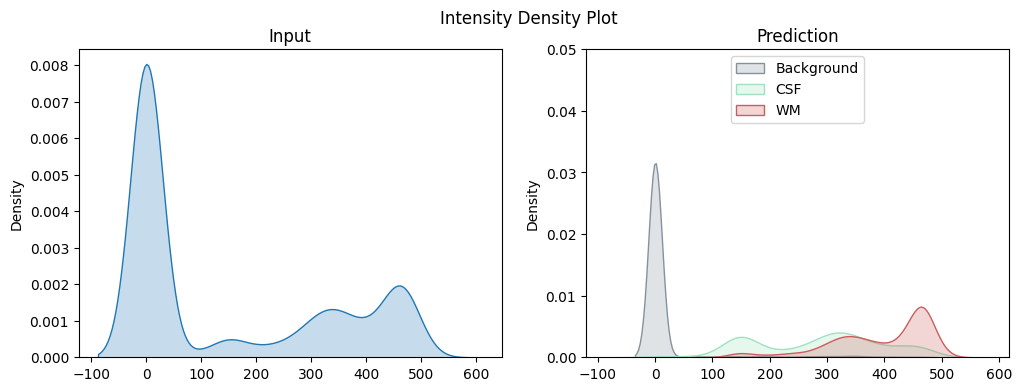

In [13]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_2 = None
pred_ = pred_seg_2[slice_id][:,:,47].flatten()
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(pred_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(pred_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(pred_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(pred_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Prediction')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])
# ----------------------------------- END -------------------------------------

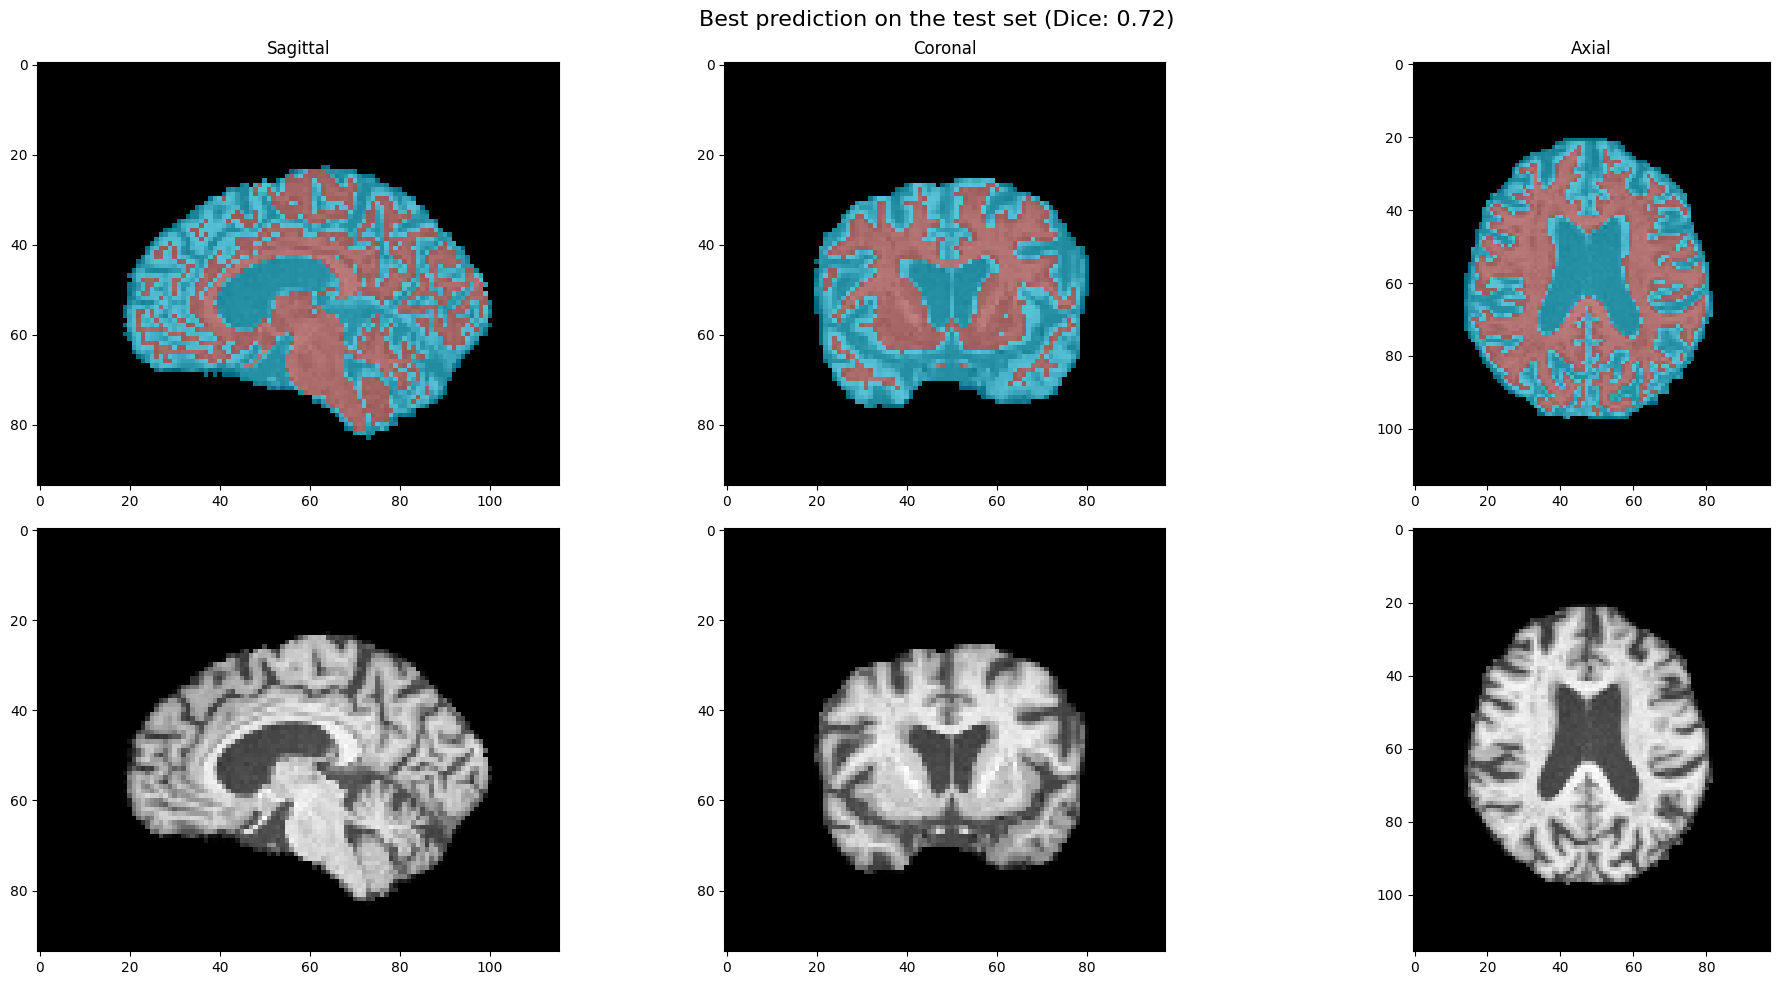

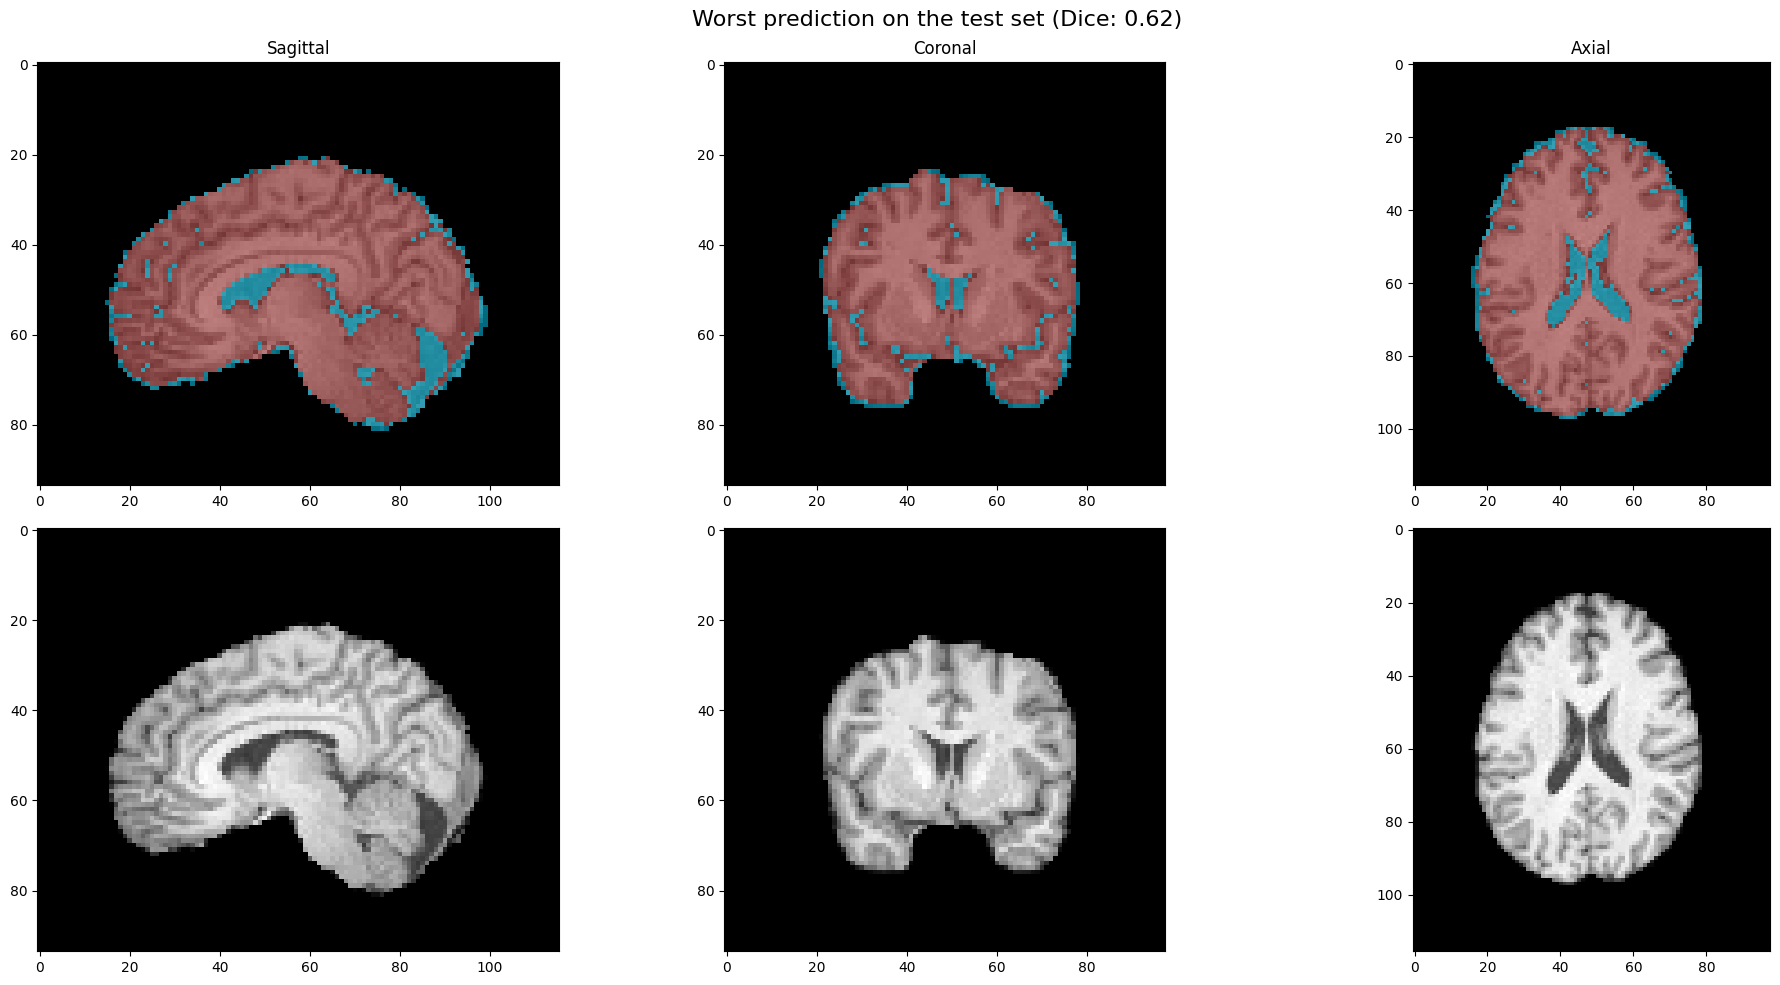

In [14]:
visualize_best_and_worst_samples(pred_seg_2)

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

In [ ]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])


## DL-based segmentation

Define and train a U-Net for segmentation (use the train, val, and test splits defined above).

Feel free to choose:
* the number of layers
* the number of features within convolutional layers
* number of convolutions within each layer
* concatenation strategy
* ...

HINT: You can use pre-defined models, e.g., from torchvision, but train them from scratch (no pre-training)

In [ ]:
# DataLoader
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

class BrainAgeDataset(Dataset):
    def __init__(self, files, segmentations, transform=None):
        self.files = files
        self.segmentations = segmentations
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        scan = load_nii(self.files[idx])
        scan = torch.from_numpy(scan)
        scan = scan.unsqueeze(dim=0)
        seg = self.segmentations[idx]
        csf, wm, gm, background = torch.zeros(seg.shape), torch.zeros(seg.shape), torch.zeros(seg.shape), torch.zeros(seg.shape)
        csf[seg == 1] = 1
        wm[seg == 2] = 1
        gm[seg == 3] = 1
        background[seg == 0] = 1

        # Stack the channels together
        seg = torch.stack([background, csf, wm, gm], dim=0)

        if self.transform is not None:
            scan = self.transform(scan)
            #seg = self.transform(seg)

        scan = F.pad(scan, (0, 34, 0, 12, 0, 30))
        seg = F.pad(seg, (0, 34, 0, 12, 0, 30))
        return (scan, seg)


In [ ]:
# Hyperparameters
batch_size = 2
learning_rate = 0.001
num_epochs = 10

In [ ]:
test_loader = DataLoader(BrainAgeDataset(test_files, segmentations_test, transform=None), batch_size=batch_size, shuffle=False)   # 65 test files
data, target = next(iter(test_loader))
print('Data shape:', data.shape)
print('Target shape:', target.shape)

In [ ]:
!pip install monai

In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(spatial_dims=3, in_channels=1, out_channels=4, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH).to(device)



In [ ]:
# Define and train a neural network (U-Net) for segmentation
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
from monai.utils import first

# DataShape (batch size, W, H, D) torch.Size([2,1,128,128,94])
# train_files, val_files, test_files

transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_loader = DataLoader(BrainAgeDataset(train_files, segmentations_train, transform=transform), batch_size=batch_size, shuffle=True) # 522 train files
val_loader = DataLoader(BrainAgeDataset(val_files, segmentations_val, transform=transform), batch_size=batch_size, shuffle=False)      # 65 val files
test_loader = DataLoader(BrainAgeDataset(test_files, segmentations_test, transform=transform), batch_size=batch_size, shuffle=False)   # 65 test files

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
val_loss_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for scan, seg in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()

        scan, seg = scan.to(device), seg.to(device)
        outputs = model(scan)
        loss = criterion(outputs, seg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    average_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")
    loss_values.append(average_loss)

    # Validation loop
    model.eval()
    val_epoch_loss = 0.0
    with torch.no_grad():
        for scan, seg in tqdm(val_loader, desc="Validation"):
            scan, seg = scan.to(device), seg.to(device)
            outputs = model(scan)
            val_loss = criterion(outputs, seg)
            val_epoch_loss += val_loss.item()
        average_val_loss = val_epoch_loss / len(val_loader)
        print(f"Validation Loss: {average_val_loss:.4f}")
        val_loss_values.append(average_val_loss)


# Test the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for scan, seg in tqdm(test_loader, desc="Testing"):
        scan, seg = scan.to(device), seg.to(device)
        outputs = model(scan)
        test_loss += criterion(outputs, seg).item()

average_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {average_test_loss:.4f}")

# ----------------------------------- END -------------------------------------

In [ ]:
# show training and validation curves
pred_seg_3 = None
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

test_loader = DataLoader(BrainAgeDataset(test_files, segmentations_test, transform=transform), batch_size=4, shuffle=False)

model.eval()
pred_segs = []

with torch.no_grad():
    for scan, seg in tqdm(test_loader, desc="Testing"):
        scan, seg = scan.to(device), seg.to(device)
        # 4 x 1 x 128 x 128 x 128
        # BATCH_SIZE x CHANNELS x W x H x D
        prediction = model(scan)
        prediction = prediction.cpu()
        # 4 x 4 x 128 x 128 x 128
        # BATCH_SIZE x CLASSES x W x H x D
        # used padding: scan = F.pad(scan, (0, 34, 0, 12, 0, 30))
        # (65, 98, 116, 94)
        probabilities = torch.softmax(prediction, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        pred_segs.append(predicted_classes[:, :98, :116, :94])

pred_seg_3 = torch.cat(pred_segs, dim=0)



In [ ]:
pred_seg_3 = [pred_seg_3[i].numpy() for i in range(pred_seg_3.shape[0])]

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_2 = None
pred_ = pred_seg_3[slice_id][:,:,47].flatten()
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(pred_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(pred_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(pred_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(pred_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Prediction')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])
# ----------------------------------- END -------------------------------------

### Evaluate the Dice scores (separately for every tissue type) for the whole test set.

In [ ]:
# Visualize individual segmentation channels for axial slice 47 of all three approaches and the ground truth in a similar style as above
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[pred_seg_1[0]==1] = 1
wm[pred_seg_1[0]==2] = 1
gm[pred_seg_1[0]==3] = 1
background[pred_seg_1[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
plt.suptitle('Segmentation for pred_seg_1')
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[pred_seg_2[0]==1] = 1
wm[pred_seg_2[0]==2] = 1
gm[pred_seg_2[0]==3] = 1
background[pred_seg_2[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
plt.suptitle('Segmentation for pred_seg_2')
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[pred_seg_3[0]==1] = 1
wm[pred_seg_3[0]==2] = 1
gm[pred_seg_3[0]==3] = 1
background[pred_seg_3[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
plt.suptitle('Segmentation for pred_seg_3')
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
plt.suptitle('Segmentation for segmentations_val')
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])


# plt_seg_1 = None
plt_seg_2 = None
plt_seg_3 = None
plt_gt = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Run this block after implementing Q3.
visualize_best_and_worst_samples(pred_seg_3)

### Summarize the results of all of the segmentation methods implemented.

In [ ]:
# Run this block after implementing Q1-3.
results_dictionary = {
    'unsupervised1': get_results_dictionary(pred_seg_1),
    'unsupervised2': get_results_dictionary(pred_seg_2),
    'u-net': get_results_dictionary(pred_seg_3),
}
plot_results_summary(results_dictionary)